# Imports

In [102]:
import os
import functools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from keras.api.models import Sequential
from keras.api.layers import Dense, Dropout, Input

from scikeras.wrappers import KerasClassifier, KerasRegressor

from pprint import pprint

# Carregando dados

In [65]:
script_dir = './'
dataset_path = os.path.join(script_dir, 'datasets', 'cars', 'data.csv')

dataset = pd.read_csv(dataset_path, encoding='ISO-8859-1')
dataset.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Pré-Processamento - Análise das colunas do dataset

In [66]:
# Retirando colunas que não serão necessárias, por conta de não serem relevantes ao preço
colunas_para_retirar = ['dateCreated', 'dateCrawled', 'nrOfPictures', 'postalCode', 'lastSeen']

# Por conta da grande variação dos nomes, vale a pena retirar para não aumentar a complexidade
colunas_para_retirar.append('name')

# Por conta de poucas amostras diferentes, o vendedor também não influenciará
colunas_para_retirar.append('seller')

# Variabilidade muito grande do offerType, dificulta a inferência de dados
colunas_para_retirar.append('offerType')

dataset = dataset.drop(colunas_para_retirar, axis=1)
dataset.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein


## Pré-Processamento - Correção de valores inconsistentes

In [67]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   price                371528 non-null  int64 
 1   abtest               371528 non-null  object
 2   vehicleType          333659 non-null  object
 3   yearOfRegistration   371528 non-null  int64 
 4   gearbox              351319 non-null  object
 5   powerPS              371528 non-null  int64 
 6   model                351044 non-null  object
 7   kilometer            371528 non-null  int64 
 8   monthOfRegistration  371528 non-null  int64 
 9   fuelType             338142 non-null  object
 10  brand                371528 non-null  object
 11  notRepairedDamage    299468 non-null  object
dtypes: int64(5), object(7)
memory usage: 34.0+ MB


In [68]:
# Valores que possivelmente form obtidos de forma incoerente
i1 = dataset.loc[dataset.price <= 10]
# dataset = dataset[dataset.price > 10]
dataset = dataset.drop(i1.index, axis=0) # Testar isso

# Valores que possivelmente form obtidos de forma incoerente
i2 = dataset.loc[dataset.price > 350000]
# dataset = dataset[dataset.price < 350000]
dataset = dataset.drop(i2.index, axis=0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 359295 entries, 0 to 371527
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   price                359295 non-null  int64 
 1   abtest               359295 non-null  object
 2   vehicleType          325748 non-null  object
 3   yearOfRegistration   359295 non-null  int64 
 4   gearbox              342058 non-null  object
 5   powerPS              359295 non-null  int64 
 6   model                341327 non-null  object
 7   kilometer            359295 non-null  int64 
 8   monthOfRegistration  359295 non-null  int64 
 9   fuelType             329903 non-null  object
 10  brand                359295 non-null  object
 11  notRepairedDamage    293308 non-null  object
dtypes: int64(5), object(7)
memory usage: 35.6+ MB


## Pré-Processamento - Valores Faltantes


In [69]:
# Uma maneira de corrigir os valores ausentes. Pode-se apagar a coluna ou substituir pelo valor médio, no caso numérico, 
# ou o item que mais se repete, no caso categórico
dataset.loc[pd.isnull(dataset['vehicleType'])]

# limousine
most_common_vehicle_type = dataset['vehicleType'].value_counts().idxmax()
print("vehicleType ", dataset['vehicleType'].value_counts().idxmax())

# manuell
most_common_gearbox = dataset['gearbox'].value_counts().idxmax()
print("gearbox ", dataset['gearbox'].value_counts().idxmax())

# golf
most_common_model = dataset['model'].value_counts().idxmax()
print("model ", dataset['model'].value_counts().idxmax())

# benzin
most_common_fuel_type = dataset['fuelType'].value_counts().idxmax()
print("fuelType ", dataset['fuelType'].value_counts().idxmax())

# nein
most_common_not_repaired_damage = dataset['notRepairedDamage'].value_counts().idxmax()
print("notRepairedDamage ", dataset['notRepairedDamage'].value_counts().idxmax())


mapa_substituicao = {
    'vehicleType': most_common_vehicle_type,
    'gearbox': most_common_gearbox,
    'model': most_common_model,
    'fueltype': most_common_fuel_type,
    'notRepairedDamage': most_common_not_repaired_damage,
}

dataset.fillna(
    value=mapa_substituicao,
    axis=0,
    inplace=True
)

dataset.dropna(
    axis=0,
    how='any',
    inplace=True
)

dataset.info()

vehicleType  limousine
gearbox  manuell
model  golf
fuelType  benzin
notRepairedDamage  nein
<class 'pandas.core.frame.DataFrame'>
Index: 329903 entries, 0 to 371527
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   price                329903 non-null  int64 
 1   abtest               329903 non-null  object
 2   vehicleType          329903 non-null  object
 3   yearOfRegistration   329903 non-null  int64 
 4   gearbox              329903 non-null  object
 5   powerPS              329903 non-null  int64 
 6   model                329903 non-null  object
 7   kilometer            329903 non-null  int64 
 8   monthOfRegistration  329903 non-null  int64 
 9   fuelType             329903 non-null  object
 10  brand                329903 non-null  object
 11  notRepairedDamage    329903 non-null  object
dtypes: int64(5), object(7)
memory usage: 32.7+ MB


## Pré-Processamento - Codificar as amostrar categorizadas

* Label Encoder

In [70]:
dataset_label_encoder = dataset.copy()

label_encoder = LabelEncoder()
dataset_label_encoder['abtest'] = label_encoder.fit_transform(dataset_label_encoder['abtest'])
classes_abtest = label_encoder.classes_

dataset_label_encoder['vehicleType'] = label_encoder.fit_transform(dataset_label_encoder['vehicleType'])
classes_tipo_veiculo = label_encoder.classes_

dataset_label_encoder['gearbox'] = label_encoder.fit_transform(dataset_label_encoder['gearbox'])
classes_cambio = label_encoder.classes_

dataset_label_encoder['model'] = label_encoder.fit_transform(dataset_label_encoder['model'])
classes_modelo = label_encoder.classes_

dataset_label_encoder['fuelType'] = label_encoder.fit_transform(dataset_label_encoder['fuelType'])
classes_tipo_combustivel = label_encoder.classes_

dataset_label_encoder['brand'] = label_encoder.fit_transform(dataset_label_encoder['brand'])
classes_marca = label_encoder.classes_

dataset_label_encoder['notRepairedDamage'] = label_encoder.fit_transform(dataset_label_encoder['notRepairedDamage'])
classes_reparo = label_encoder.classes_


dataset_label_encoder.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,1,6,1993,1,0,118,150000,0,1,38,1
1,18300,1,3,2011,1,190,118,125000,5,3,1,0
2,9800,1,7,2004,0,163,119,125000,8,3,14,1
3,1500,1,4,2001,1,75,118,150000,6,1,38,1
4,3600,1,4,2008,1,69,103,90000,7,3,31,1


## Pré-Processamento - Codificar as amostrar categorizadas

* One Hot Encoder

In [74]:
print(f"Classes de abtest ({classes_abtest.size}): ", classes_abtest[-5:])
print(f"Classes de tipo veículo ({classes_tipo_veiculo.size}): ", classes_tipo_veiculo[-5:])
print(f"Classes de cambio ({classes_cambio.size}): ", classes_cambio[-5:])
print(f"Classes de modelo ({classes_modelo.size}): ", classes_modelo[-5:])
print(f"Classes de tipo de combustível ({classes_tipo_combustivel.size}): ", classes_tipo_combustivel[-5:])
print(f"Classes de marca ({classes_marca.size}): ", classes_marca[-5:])
print(f"Classes de reparo ({classes_reparo.size}): ", classes_reparo[-5:])

Classes de abtest (2):  ['control' 'test']
Classes de tipo veículo (8):  ['coupe' 'kleinwagen' 'kombi' 'limousine' 'suv']
Classes de cambio (2):  ['automatik' 'manuell']
Classes de modelo (251):  ['yaris' 'yeti' 'ypsilon' 'z_reihe' 'zafira']
Classes de tipo de combustível (7):  ['cng' 'diesel' 'elektro' 'hybrid' 'lpg']
Classes de marca (40):  ['suzuki' 'toyota' 'trabant' 'volkswagen' 'volvo']
Classes de reparo (2):  ['ja' 'nein']


In [75]:
dataset_one_hot = pd.get_dummies(dataset_label_encoder, columns=['abtest', 'vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage'], dtype=np.int8)
dataset_one_hot.head()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,abtest_0,abtest_1,vehicleType_0,vehicleType_1,vehicleType_2,...,brand_32,brand_33,brand_34,brand_35,brand_36,brand_37,brand_38,brand_39,notRepairedDamage_0,notRepairedDamage_1
0,480,1993,0,150000,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,9800,2004,163,125000,8,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1500,2001,75,150000,6,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,3600,2008,69,90000,7,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Contrução da Rede Neural de Regressão

In [78]:
saida = dataset_one_hot['price'].values
entradas = dataset_one_hot.drop('price', axis=1).values

print(f"Shape entradas: {entradas.shape}")

Shape entradas: (329903, 316)


In [79]:
modelo = Sequential(
    layers=[
        Input(shape=[entradas.shape[1],]),
    ]
)

modelo.add(
    Dense(
        units=158,
        activation='relu', # é rocmendado utilizar relu para problemas de regressão
        kernel_initializer='random_uniform'
    )
)

modelo.add(
    Dense(
        units=80,
        activation='relu', # é rocmendado utilizar relu para problemas de regressão
        kernel_initializer='random_uniform'
    )
)

modelo.add(
    Dense(
        units=1,
        activation='linear',
    )
)

modelo.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_absolute_error']
)

In [82]:
modelo.fit(
    x=entradas,
    y=saida,
    batch_size=300,
    epochs=100,
    validation_split=0.2
)

Epoch 1/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4339.4971 - mean_absolute_error: 4339.4971
Epoch 2/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3250.9482 - mean_absolute_error: 3250.9482
Epoch 3/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3003.3823 - mean_absolute_error: 3003.3823
Epoch 4/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2845.0256 - mean_absolute_error: 2845.0256
Epoch 5/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2774.8823 - mean_absolute_error: 2774.8823
Epoch 6/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2717.2642 - mean_absolute_error: 2717.2642
Epoch 7/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2716.3008 - mean_absolute_error: 2716.3008
Epoch 8/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2674.6628 - mean_absolute_error: 2674.6628
Epoch 9/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2618.6592 - mean_absolute_error: 2618.6592
Epoch 10/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 6s

## Usando a validação cruzada

In [107]:
entradas.shape[1]

316

In [129]:
def criar_modelo(num_entradas=316, activation = 'relu', kernel_initializer = 'random_uniform', dropout = 0.0, nome = 'Used_cars',
                 optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mean_absolute_error']) -> Sequential:
    modelo = Sequential(
        name=nome,
        layers=[
            Input(shape=[num_entradas,]),
        ]
    )

    num_entradas_hl_1 = int(round((num_entradas+1)/2, 0))
    modelo.add(
        Dense(
            units=num_entradas_hl_1,
            activation=activation, # é rocmendado utilizar relu para problemas de regressão
            kernel_initializer=kernel_initializer
        )
    )
    if (dropout > 0):
        modelo.add(
            Dropout(
                rate=dropout
            )
        )

    num_entradas_hl_2 = int(round((num_entradas_hl_1+1)/2, 0))
    modelo.add(
        Dense(
            units=num_entradas_hl_2,
            activation=activation, # é rocmendado utilizar relu para problemas de regressão
            kernel_initializer=kernel_initializer
        )
    )
    if (dropout > 0):
        modelo.add(
            Dropout(
                rate=dropout
            )
        )

    modelo.add(
        Dense(
            units=1,
            activation='linear'
        )
    )

    modelo.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return modelo

In [130]:
regressor = KerasRegressor(
    model=criar_modelo,
    epochs=100,
    batch_size=300
)

In [131]:
resultados = cross_val_score(
    estimator=regressor,
    X=entradas,
    y=saida,
    cv=10,
    scoring='neg_mean_absolute_error',
    n_jobs=3,
    verbose=2
)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 19.4min finished


Média: 2263.2301
Desvio Padrão: 41.8189


C:\Users\joao.turra\AppData\Local\Temp\ipykernel_5840\2941526507.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


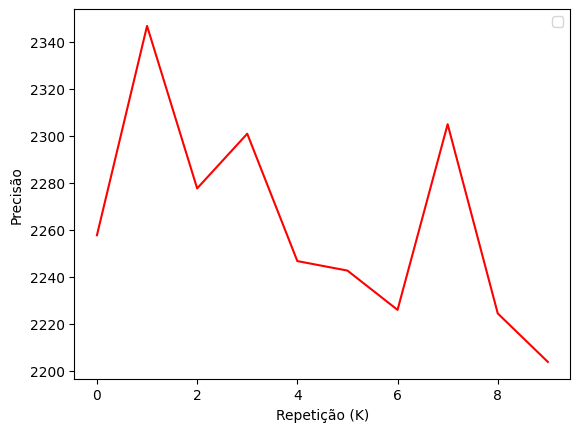

In [134]:
resultados = np.absolute(resultados)
media = resultados.mean()
desvio_padrao = resultados.std()

print(f"Média: {round(media, 4)}")
print(f"Desvio Padrão: {round(desvio_padrao, 4)}")
plt.plot(resultados, 'r')
plt.xlabel("Repetição (K)")
plt.ylabel("Precisão")
plt.legend()
plt.show()

## Aplicando o Tunning

In [143]:
regressor_tunnning = KerasRegressor(
    model=criar_modelo
)

parametros_tunnning = {
    'model__num_entradas': [entradas.shape[1]],
    'model__activation': ['relu'],
    'model__kernel_initializer': ['random_uniform'],
    'model__dropout': [0.0, 0.2],
    'model__optimizer': ['adam'],
    'model__loss': ['mean_squared_error'],
    'model__metrics': [['mean_squared_error']],
    'epochs': [100],
    'batch_size': [300]
}

tunning = GridSearchCV(
    estimator=regressor_tunnning,
    param_grid=parametros_tunnning,
    scoring="neg_root_mean_squared_error",
    n_jobs=4,
    cv=5,
    verbose=2,
    pre_dispatch=6
)

In [144]:
tunning.fit(
    X=entradas,
    y=saida
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Epoch 1/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4430.0879 - mean_absolute_error: 4430.0879
Epoch 2/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3360.4497 - mean_absolute_error: 3360.4500
Epoch 3/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3145.6709 - mean_absolute_error: 3145.6709
Epoch 4/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3055.9802 - mean_absolute_error: 3055.9805
Epoch 5/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2935.6240 - mean_absolute_error: 2935.6240
Epoch 6/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2798.2129 - mean_absolute_error: 2798.2129
Epoch 7/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 2735.4431 - mean_absolute_error: 2735.4431
Epoch 8/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2702.1558 - mean_absolute_error: 2702.1558
Epoch 9/100
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2646.0110 - mean_absolute_er

GridSearchCV(cv=5,
             estimator=KerasRegressor(model=<function criar_modelo at 0x000002244773FC40>),
             n_jobs=4,
             param_grid={'batch_size': [300], 'epochs': [100],
                         'model__activation': ['relu'],
                         'model__dropout': [0.0, 0.2],
                         'model__kernel_initializer': ['random_uniform'],
                         'model__loss': ['mean_absolute_error',
                                         'mean_squared_error'],
                         'model__metrics': [['mean_absolute_error'],
                                            ['mean_squared_error']],
                         'model__num_entradas': [316],
                         'model__optimizer': ['adam']},
             pre_dispatch=6, scoring='neg_root_mean_squared_error', verbose=2)

In [145]:
best_model = tunning.best_estimator_
best_score = tunning.best_score_
best_params = tunning.best_params_

print(f"Melhor precisão: {best_score}")
print(f"Melhores parâmetros: {best_params}")

Melhor precisão: -5130.887023589655
Melhores parâmetros: {'batch_size': 300, 'epochs': 100, 'model__activation': 'relu', 'model__dropout': 0.0, 'model__kernel_initializer': 'random_uniform', 'model__loss': 'mean_absolute_error', 'model__metrics': ['mean_absolute_error'], 'model__num_entradas': 316, 'model__optimizer': 'adam'}
